# Import libraries

In [ ]:
!pip install catboost
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 24.0 MB/s eta 0:00:00


In [ ]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

import shap

# Load and inspect dataset

In [ ]:
# URL of the raw CSV file
url = 'https://raw.githubusercontent.com/EunCheolChoi0123/COMM557Tutorial/main/Tutorial%207%20Supervised%20Learning/disinfo_demo.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame
print(df.head())


   friends_count  listed_count  followers_count  favourites_count  \
0            331             0              260                 1   
1            163             0               16               645   
2            732             2             1860             15471   
3            313             0               63              5158   
4              5             0                0                 1   

   statuses_count  toxicity  severe_toxicity   obscene  identity_attack  \
0            8715  0.000536         0.000001  0.000027         0.000091   
1             395  0.000424         0.000001  0.000025         0.000082   
2            7993  0.000361         0.000001  0.000025         0.000073   
3            1527  0.000649         0.000002  0.000047         0.000076   
4              32  0.000382         0.000001  0.000025         0.000071   

     insult    threat  sexual_explicit  tweet_length  emotion_anger  \
0  0.000137  0.000021         0.000014            80       0.40

In [ ]:
df.describe()

,friends_count,listed_count,followers_count,favourites_count,statuses_count,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,tweet_length,emotion_anger,emotion_disgust,emotion_fear,emotion_joy,emotion_sadness,emotion_surprise
count,23006.000000,23006.000000,2.300600e+04,23006.000000,2.300600e+04,23006.000000,2.300600e+04,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000
mean,1262.501652,20.580327,3.739228e+03,7405.031992,1.700014e+04,0.068814,9.386565e-04,0.023170,0.007565,0.036258,0.003418,0.005466,189.781709,0.479620,0.563451,0.311317,0.257723,0.321128,0.152695
std,6335.218298,144.309955,3.947294e+04,34633.585648,8.825056e+04,0.208203,1.215413e-02,0.132582,0.051259,0.151128,0.029483,0.054507,76.715255,0.286152,0.245340,0.184627,0.220580,0.216331,0.103065
min,0.000000,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000320,9.103375e-07,0.000019,0.000050,0.000074,0.000013,0.000009,10.000000,0.008103,0.009189,0.007302,0.014658,0.012149,0.012516
25%,11.000000,0.000000,2.000000e+00,2.000000,3.900000e+01,0.000514,1.423469e-06,0.000030,0.000085,0.000124,0.000022,0.000015,125.000000,0.222893,0.356632,0.172810,0.085448,0.155468,0.074653
50%,63.000000,0.000000,1.700000e+01,27.000000,3.760000e+02,0.000925,1.804306e-06,0.000045,0.000125,0.000196,0.000034,0.000022,202.000000,0.432783,0.565164,0.273224,0.185201,0.265393,0.127271
75%,397.000000,1.000000,2.280000e+02,699.750000,5.413750e+03,0.005660,4.863764e-06,0.000163,0.000454,0.000914,0.000110,0.000080,265.000000,0.742413,0.784834,0.410864,0.364252,0.431229,0.202570
max,227109.000000,5272.000000,1.807874e+06,935901.000000,2.327963e+06,0.998597,4.466912e-01,0.987944,0.910249,0.993536,0.889906,0.980541,304.000000,0.981426,0.978561,0.980683,0.991076,0.988139,0.769021


In [ ]:
# Columns to be scaled
cols_to_be_scaled = list(filter(lambda x: 'count' in x,list(df.columns)))

#sc = StandardScaler()
#df_removed[cols_to_be_scaled] = sc.fit_transform(df_removed[cols_to_be_scaled])
df[cols_to_be_scaled] = np.log10(df[cols_to_be_scaled] + 1)

In [ ]:
df.describe()

,friends_count,listed_count,followers_count,favourites_count,statuses_count,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,tweet_length,emotion_anger,emotion_disgust,emotion_fear,emotion_joy,emotion_sadness,emotion_surprise
count,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,2.300600e+04,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000,23006.000000
mean,1.840156,0.306382,1.510467,1.763461,2.667537,0.068814,9.386565e-04,0.023170,0.007565,0.036258,0.003418,0.005466,189.781709,0.479620,0.563451,0.311317,0.257723,0.321128,0.152695
std,1.090489,0.612239,1.260047,1.491488,1.322331,0.208203,1.215413e-02,0.132582,0.051259,0.151128,0.029483,0.054507,76.715255,0.286152,0.245340,0.184627,0.220580,0.216331,0.103065
min,0.000000,0.000000,0.000000,0.000000,0.301030,0.000320,9.103375e-07,0.000019,0.000050,0.000074,0.000013,0.000009,10.000000,0.008103,0.009189,0.007302,0.014658,0.012149,0.012516
25%,1.079181,0.000000,0.477121,0.477121,1.602060,0.000514,1.423469e-06,0.000030,0.000085,0.000124,0.000022,0.000015,125.000000,0.222893,0.356632,0.172810,0.085448,0.155468,0.074653
50%,1.806180,0.000000,1.255273,1.447158,2.576341,0.000925,1.804306e-06,0.000045,0.000125,0.000196,0.000034,0.000022,202.000000,0.432783,0.565164,0.273224,0.185201,0.265393,0.127271
75%,2.599883,0.301030,2.359835,2.845563,3.733578,0.005660,4.863764e-06,0.000163,0.000454,0.000914,0.000110,0.000080,265.000000,0.742413,0.784834,0.410864,0.364252,0.431229,0.202570
max,5.356236,3.722058,6.257168,5.971230,6.366976,0.998597,4.466912e-01,0.987944,0.910249,0.993536,0.889906,0.980541,304.000000,0.981426,0.978561,0.980683,0.991076,0.988139,0.769021


In [ ]:
## Apply numerical labels
df['label'] = df['label'].apply(lambda x: 1 if isinstance(x, str) and x.strip() == "pro" else 0)

In [ ]:
df['label'].value_counts()

,count
label,
1,18939
0,4067


In [ ]:
df.columns = ['Friends', 'Listed', 'Followers', 'Liking',
       'Tweets+RTs',
       'Toxicity', 'Severe Toxicity', 'Obscene', 'Identity Attack', 'Insult',
       'Threat', 'Sexually Explicit', 'Tweet Length', 'Anger',
       'Disgust', 'Fear', 'Joy', 'Sadness',
       'Surprise', 'Label']

# Correlation matrix

<Axes: >

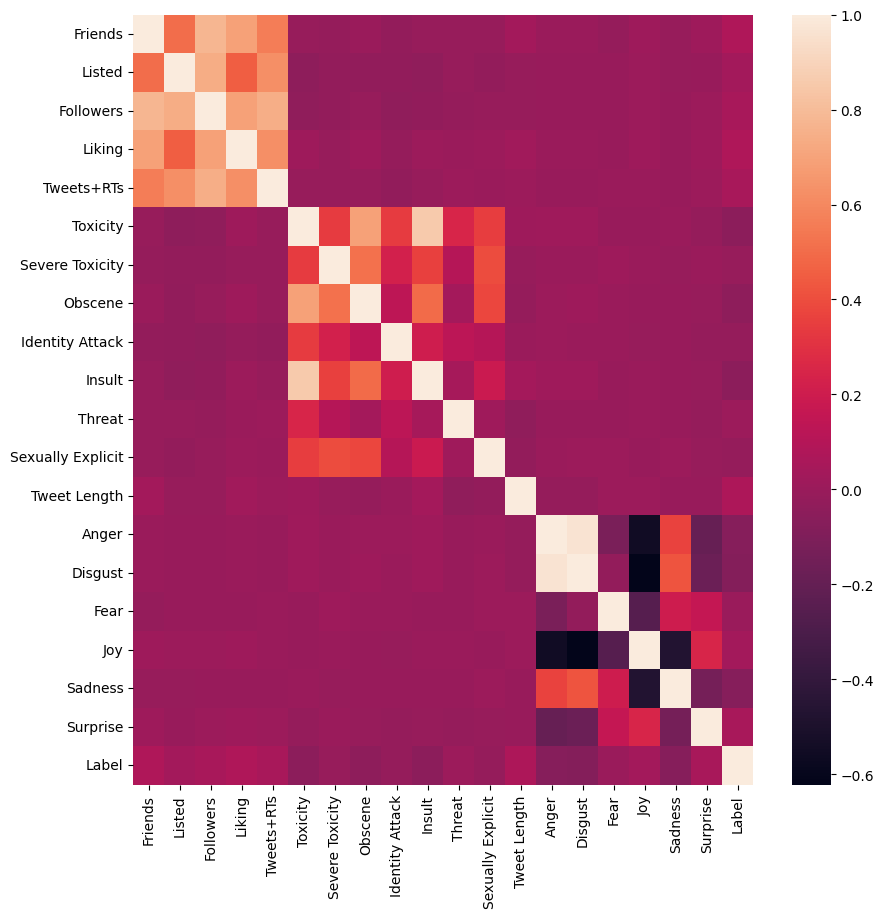

In [ ]:
## Correlation Matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

# Plot Correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(corr)

# Train-test split
- When imbalanced, oversampling is a good strategy when there are few data points, while undersampling is good when there are potentially many similar data points.
- https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets

In [ ]:
# Get the number of samples for each label
label_counts = df['Label'].value_counts()

# Find the label with the smaller number of samples
min_samples = min(label_counts)

# Create a balanced dataset by sampling the same number of samples from each label
balanced_df = pd.concat([
    df[df['Label'] == 0].sample(n=min_samples, random_state=42),
    df[df['Label'] == 1].sample(n=min_samples, random_state=42)
])

# Print the new label counts
print(balanced_df['Label'].value_counts())

Label
0    4067
1    4067
Name: count, dtype: int64


In [ ]:
# Train Test Split
X = balanced_df.drop('Label',axis=1)
y = balanced_df['Label']

# X = df_removed.drop('Entailment',axis=1)
# y = df_removed['Entailment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
metrics_dict = {}

# Regression models
- StatQuest Logistic Regression, Regularization (playlist): https://www.youtube.com/watch?v=yIYKR4sgzI8&list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe

In [ ]:
log_model = LogisticRegression(solver='newton-cg')
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, log_preds))
classification_report_log = classification_report(y_test, log_preds, output_dict=True)

metrics_dict['logistic_regression'] = classification_report_log

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.58      0.59       837
           1       0.57      0.60      0.59       790

    accuracy                           0.59      1627
   macro avg       0.59      0.59      0.59      1627
weighted avg       0.59      0.59      0.59      1627



In [ ]:
## Ridge Classifier
ridge_model = RidgeClassifier()
ridge_model.fit(X_train, y_train)
ridge_preds = ridge_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, ridge_preds))
classification_report_ridge = classification_report(y_test, ridge_preds, output_dict=True)

metrics_dict['ridge_regression'] = classification_report_ridge

In [ ]:
## Lasso Regression
lasso_model = LogisticRegression(penalty='l1',solver='liblinear')
lasso_model.fit(X_train, y_train)
lasso_preds = lasso_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, lasso_preds))
classification_report_lasso = classification_report(y_test, lasso_preds, output_dict=True)

metrics_dict['lasso_regression'] = classification_report_lasso

# Tree Models
- StatQuest Decision Trees (playlist): https://www.youtube.com/watch?v=_L39rN6gz7Y&list=PLblh5JKOoLUKAtDViTvRGFpphEc24M-QH
- StatQuest Random Forest (playlist): https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&list=PLblh5JKOoLUIE96dI3U7oxHaCAbZgfhHk

In [ ]:
## Decision Tree

dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, y_train)
dec_tree_preds = dec_tree.predict(X_test)
print("Classification Report:\n", classification_report(y_test, dec_tree_preds))
classification_report_dec = classification_report(y_test, dec_tree_preds, output_dict=True)

metrics_dict['decision_tree'] = classification_report_dec

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.61      0.61       837
           1       0.59      0.59      0.59       790

    accuracy                           0.60      1627
   macro avg       0.60      0.60      0.60      1627
weighted avg       0.60      0.60      0.60      1627



In [ ]:
## Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

In [ ]:
print("Classification Report:\n", classification_report(y_test, rf_preds))
classification_report_rf = classification_report(y_test, rf_preds, output_dict=True)

metrics_dict['random_forest'] = classification_report_rf

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.65      0.66       837
           1       0.64      0.66      0.65       790

    accuracy                           0.66      1627
   macro avg       0.66      0.66      0.66      1627
weighted avg       0.66      0.66      0.66      1627



# Gradient-boosted trees
- StatQuest Gradient Boosting (playlist): https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Check if GPU is available
try:
    import cupy as cp
    print("CuPy is available, using GPU for XGBoost.")
    xgb_model = xgb.XGBClassifier(tree_method = "hist", device = "cuda")  # Use GPU for XGBoost
except ImportError:
    print("CuPy not found. Using CPU for XGBoost.")
    xgb_model = xgb.XGBClassifier()

# Random hyperparameter sweeping (modified to use the defined xgb_model)
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators': stats.randint(50, 200)
}

random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')
random_search.fit(X_train, y_train)

print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

In [ ]:
# Train the XGBoost model with the best hyperparameters
best_xgb_model = xgb.XGBClassifier(**random_search.best_params_)
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
xgb_preds = best_xgb_model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, xgb_preds))
classification_report_xgb = classification_report(y_test, xgb_preds, output_dict=True)
metrics_dict['xgboost'] = classification_report_xgb

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.64      0.66       837
           1       0.64      0.68      0.66       790

    accuracy                           0.66      1627
   macro avg       0.66      0.66      0.66      1627
weighted avg       0.66      0.66      0.66      1627



In [ ]:
# Define the hyperparameter grid for CatBoost
param_grid = {
    'iterations': [100, 200, 300],  # Number of boosting iterations
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage used in update to prevent overfitting
    'depth': [4, 6, 8],  # Depth of the trees
    'l2_leaf_reg': [1, 3, 5],  # L2 regularization term on weights of leaves
    'border_count': [32, 64, 128], # Number of splits for numerical features
    'random_strength': [1, 5, 10] # Random strength for bagging
}

# Initialize CatBoostClassifier with task_type='GPU' for GPU usage
catboost_model = CatBoostClassifier(task_type='GPU', verbose=0)

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_catboost = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=5,  # Number of random combinations to try
    cv=3,  # Number of cross-validation folds
    scoring='accuracy',
    random_state=42,
    verbose=1
)

# Fit the model with the training data
random_search_catboost.fit(X_train, y_train)


# Get the best hyperparameters and train the final model
best_params = random_search_catboost.best_params_
print("Best hyperparameters:", best_params)


best_catboost_model = CatBoostClassifier(**best_params, task_type="GPU", verbose=0)
best_catboost_model.fit(X_train, y_train)


# Make predictions on the test data
catboost_preds = best_catboost_model.predict(X_test)

# Evaluate the model
print("Classification Report (CatBoost):\n", classification_report(y_test, catboost_preds))

classification_report_catboost = classification_report(y_test, catboost_preds, output_dict=True)
metrics_dict['catboost'] = classification_report_catboost

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best hyperparameters: {'random_strength': 5, 'learning_rate': 0.2, 'l2_leaf_reg': 5, 'iterations': 100, 'depth': 6, 'border_count': 32}
Classification Report (CatBoost):
               precision    recall  f1-score   support

           0       0.67      0.63      0.65       837
           1       0.63      0.68      0.65       790

    accuracy                           0.65      1627
   macro avg       0.65      0.65      0.65      1627
weighted avg       0.65      0.65      0.65      1627



# Explanable AI (XAI)
- Feature importance: "they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree." (https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
- Permutation importance: "randomly shuffling the values of a single feature and observing the resulting degradation of the model’s score" (https://scikit-learn.org/1.5/modules/permutation_importance.html)
- SHAP values: In this visualization, each data point corresponds to a sample. The horizontal position of a point reflects its influence on the model's output, while its color, ranging from blue to red, signifies the feature's magnitude from low to high. (https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)

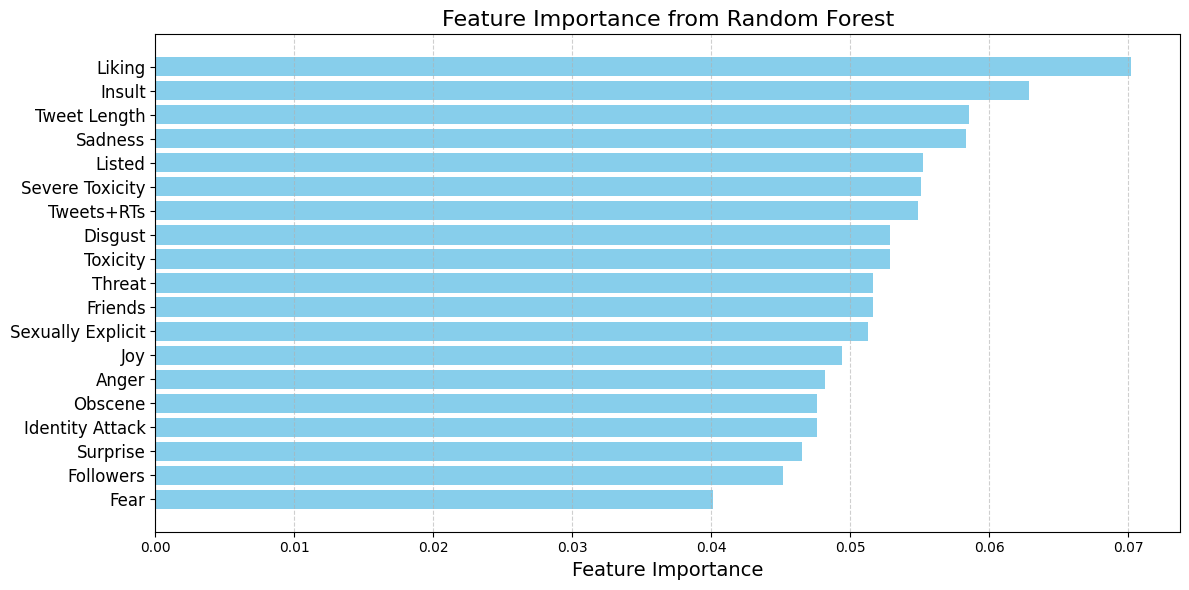

In [ ]:
feature_importance = best_xgb_model.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]  # Sort in descending order

fig = plt.figure(figsize=(12, 6))
# Use feature_importance directly instead of feature_importance.importances_mean
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color='skyblue')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx], fontsize=12)
plt.xlabel('Feature Importance', fontsize=14) # Changed label to reflect the data being plotted
plt.title('Feature Importance from Random Forest', fontsize=16) # Changed title to be more specific
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

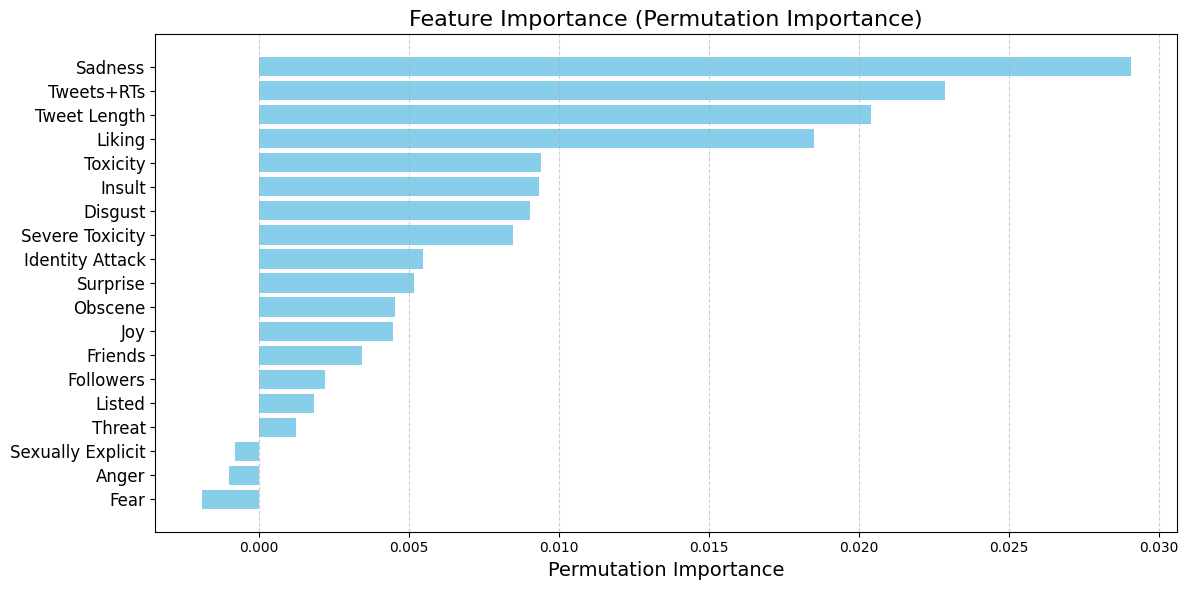

In [ ]:
perm_importance = permutation_importance(best_xgb_model, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]  # Sort in descending order

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color='skyblue')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx], fontsize=12)
plt.xlabel('Permutation Importance', fontsize=14)
plt.title('Feature Importance (Permutation Importance)', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

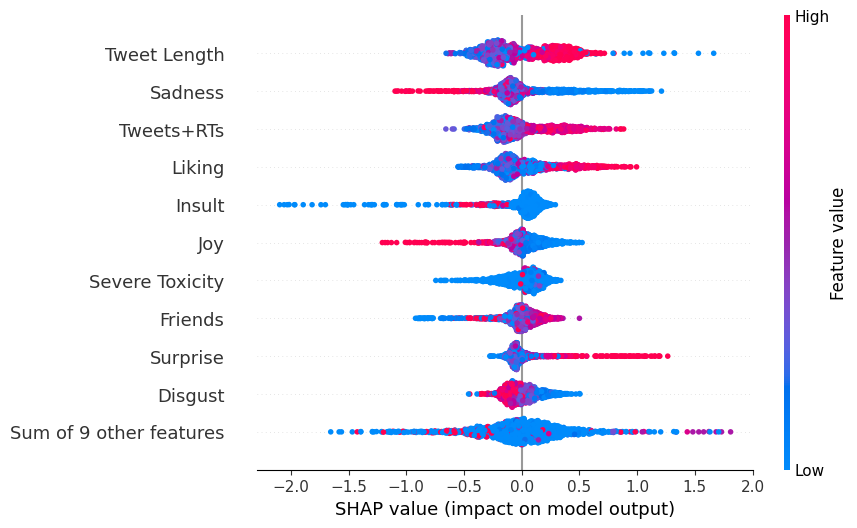

In [ ]:
# Use all samples for SHAP values
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test) # Use X_test instead of X1000
shap.plots.beeswarm(shap.Explanation(shap_values, data=X_test, feature_names=X_test.columns), max_display = 11)

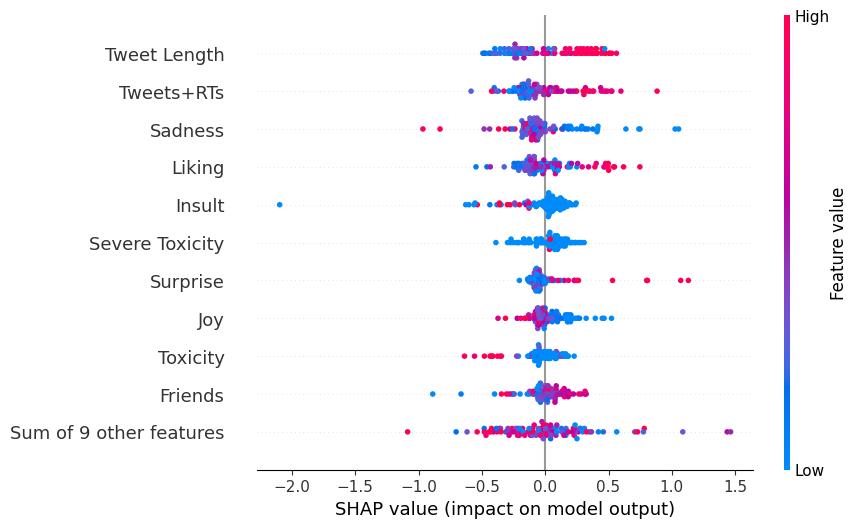

In [ ]:
# sample 100
X100 = shap.utils.sample(X_test, 100)
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X100)
shap.plots.beeswarm(shap.Explanation(shap_values, data=X100, feature_names=X100.columns), max_display = 11)